In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.95:44614 Dashboard: http://10.148.1.95:8787/status,Cluster Workers: 10 Cores: 140 Memory: 600.00 GB


## Taux_h = tau_x/(h*rho)

In [5]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'
ds_TAUX_H  = xr.open_zarr(store_dir_zarr+'TAUX_ELD_rotation_f01.zarr')
ds_TAUX_H

<xarray.Dataset>
Dimensions:    (i: 1080, j: 1080, time: 100)
Coordinates:
    CS         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    Depth      (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    SN         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    XC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    YC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    face       int64 ...
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    niter      (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    rA         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
  * time       (time) datetime64[ns] 2011-11-23T08:00:00 ... 2011-11-27T11:00:00
Data variables:
    oceTAUX_H  (time, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.n

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


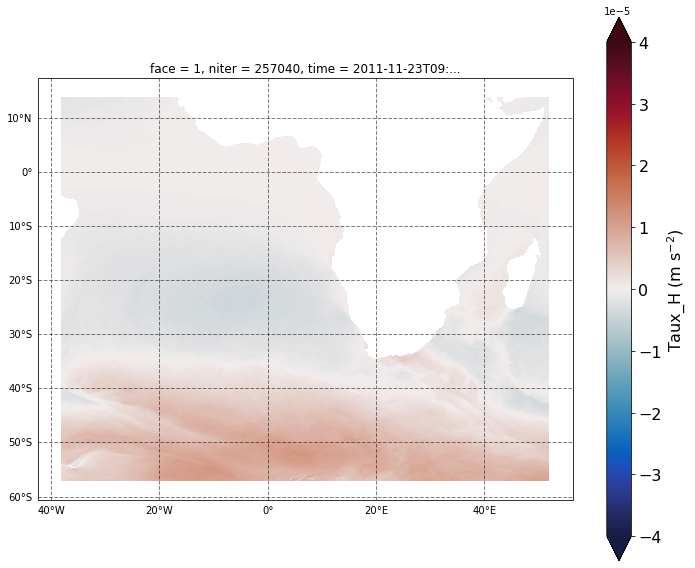

In [6]:
Taux_H = ds_TAUX_H.oceTAUX_H.isel(time=1)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

cax = Taux_H.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-4e-5, vmax=4e-5, cmap = cm.balance, add_colorbar = False)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

plt.ylabel('Latitude',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
ax.tick_params(labelsize=16)

cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Taux_H (m s$^{-2}$)', fontsize=16)
                  

## save movies

In [7]:
ds = ds_TAUX_H.isel(time=slice(0,100))
ds

<xarray.Dataset>
Dimensions:    (i: 1080, j: 1080, time: 100)
Coordinates:
    CS         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    Depth      (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    SN         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    XC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    YC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    face       int64 ...
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    niter      (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    rA         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
  * time       (time) datetime64[ns] 2011-11-23T08:00:00 ... 2011-11-27T11:00:00
Data variables:
    oceTAUX_H  (time, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.n

In [8]:


_default_cmaps = {'SSU': cm.balance, 'SSV': cm.balance,
           'SSU_geo': cm.balance, 'SSV_geo': cm.balance,
           'Eta': plt.get_cmap('RdGy_r'), 
           'SST': cm.thermal, 'SSS': cm.haline}

def _get_cmap(v, cmap):
    if cmap is None and v.name in _default_cmaps:
        return _default_cmaps[v.name]
    elif cmap is not None:
        return cmap
    else:
        return plt.get_cmap('magma')

    
    
def plot_scalar(v, colorbar=False, title=None, vmin=None, vmax=None, savefig=None, figsize=(10,10), offline=False, cmap=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        colmap = _get_cmap(v, cmap)
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
        try:
            im = v.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=colmap)
            fig.colorbar(im)
            gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
                            alpha=0.5, linestyle='--')
            gl.xlabels_top = False
            if coast_resolution is not None:
                ax.coastlines(resolution=coast_resolution, color='k')
        except:
            pass
        #
        if title is not None:
            ax.set_title(title)
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        #if not offline:
        #    plt.show()
        return fig, ax
    
    
face = 1
vmin, vmax = -4e-5, 4e-5

#delete all figures beforehand
figdir = datawork+'others/figs/'

lds = ds

def process(ds, i, overwrite=True):    
    
    Taux_H = ds['oceTAUX_H']
    #print(Taux_H)
    mtime = Taux_H['niter'].values/86400.
    figname = figdir+'Taux_H_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'Taux_H %.3f' %mtime
        plot_scalar(Taux_H, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=False, figsize=(15,10))
                    #offline=False, coast_resolution='110m', figsize=(15,10))
        #
        m = float(Taux_H.mean().values)
    else:
        m = -1.
    return m

#I = range(len(ds['time']))
I = range(0,100)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]


range(0, 100)


In [9]:
%time results = compute(*values, scheduler='processes')

CPU times: user 13.8 s, sys: 4.7 s, total: 18.5 s
Wall time: 18.6 s


In [10]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1